## Helpers and Imports

In [123]:
import pandas as pd
import numpy as np
import torch
from typing import Tuple, Dict, Any
import plotly.graph_objects as go
from plotly.subplots import make_subplots



In [69]:
import numpy as np

def superposition_measure(x_i: np.ndarray, X: np.ndarray) -> float:
    """Σ_j ( x̂_i · x_j )²  – ‘superposition score’ for one feature."""
    x_hat_i = x_i / np.linalg.norm(x_i)
    overlaps = X @ x_hat_i
    return float(np.sum(overlaps**2))


def color_from_xy(x: float, y: float, max_x: float = 1.0, max_y: float = 1.0) -> tuple[float, float, float]:
    """
    Reconstruct the paper’s legend → RGB.
      • x (horizontal)  = superposition score, clipped to ≤ 1
          0 ⇒ blue,  1 ⇒ red
      • y (vertical)    = ‖W_i‖,           clipped to ≤ 1
          0 ⇒ white, 1 ⇒ full-strength hue
    """
    # x = np.clip(x, 0, 1)
    # y = np.clip(y, 0, 1)
    max_x = max(max_x, 1)
    max_y = max(max_y, 1)

    base = np.array([x, 0.0, max_x - x])      # blue→red ramp
    return tuple(y * base + (max_y - y))        # mix with white


def rgb_to_hex(rgb: tuple[float, float, float]) -> str:
    return '#{:02x}{:02x}{:02x}'.format(
        *(int(round(255 * c)) for c in rgb)
    )


In [70]:
import pandas as pd

def compute_feature_metrics(W: np.ndarray) -> pd.DataFrame:
    """
    For every row of a weight-matrix **W** (shape = (n_features, d)) return:

      • norm         – ‖W_i‖
      • super_score  – Σ_j (x̂_i·x_j)²
      • x_coord      – clipped super_score  (what the paper puts on x-axis)
      • y_coord      – clipped norm         (what the paper puts on y-axis)
      • colour_hex   – HTML / matplotlib colour that matches the legend
    """
    if torch.is_tensor(W):
        W = W.detach().cpu().numpy()
    
    rows = []
    for i in range(W.shape[0]):
        norm_i = np.linalg.norm(W[i])
        sup_i  = superposition_measure(W[i], W)
        x_i    = sup_i # min(sup_i, 1.0)
        y_i    = norm_i # min(norm_i, 1.0)
        rows.append(
            (norm_i, sup_i, x_i, y_i, rgb_to_hex(color_from_xy(x_i, y_i)))
        )

    return pd.DataFrame(
        rows,
        columns=["norm", "super_score", "x_coord", "y_coord", "colour_hex"],
    )


In [92]:
dim_scalar = 1

def color_from_metrics(norm: float, superpos: float, max_norm: float, max_super: float) -> Tuple[float, float, float]:
    """
    Map (norm, superpos) to an RGB tuple with:
    - Top right (high norm, high super) -> Red
    - Top left (high norm, low super) -> Blue
    - Bottom (low norm) -> White
    
    Args:
        norm: L2 norm of the weights
        superpos: Superposition score
        max_norm: Maximum norm for normalization
        max_super: Maximum superposition score for normalization
    """

    # Normalize inputs to [0,1]
    y = np.clip(norm / max_norm, 0.0, dim_scalar)      # Vertical axis (norm)
    x = np.clip(superpos / max_super, 0.0, dim_scalar)  # Horizontal axis (superposition)
    
    # Create color components
    red = y * x           # Increases towards top-right
    blue = y * (dim_scalar - x)    # Increases towards top-left
    # All components approach 1 (white) as y approaches 0 (bottom)
    white_blend = dim_scalar - y
    
    # Blend with white
    r = red + white_blend
    g = white_blend
    b = blue + white_blend
    
    # Normalize to [0,1]
    return (
        min(dim_scalar, max(0.0, r)),
        min(dim_scalar, max(0.0, g)),
        min(dim_scalar, max(0.0, b))
    )

def plot_colormap_plotly(n: int = 200, *, max_norm: float = 1.0, max_super: float = 1.0):
    """
    Interactive Plotly visualization of the (norm, superposition) → color mapping.
    - x-axis: superposition (0 → 1)
    - y-axis: norm (0 → 1), origin at bottom (like origin='lower' in matplotlib)
    """
    # Build RGB image using your color_from_metrics(norm, superpos, max_norm, max_super)
    color_grid = np.zeros((n, n, 3), dtype=float)  # [rows (norm), cols (super)]
    norms = np.linspace(0.0, dim_scalar, n)
    supers = np.linspace(0.0, dim_scalar, n)
    for i, y in enumerate(norms):
        for j, x in enumerate(supers):
            color_grid[i, j] = color_from_metrics(
                norm=y, superpos=x, max_norm=max_norm, max_super=max_super
            )

    # Plotly expects 0-255 uint8 for go.Image
    img = (np.clip(color_grid, 0.0, 1) * 255).astype(np.uint8)

    # Each pixel spans dx, dy to map [0,1] on both axes
    dx = 1 / (n - 1) * dim_scalar
    dy = 1 / (n - 1) * dim_scalar

    fig = go.Figure(go.Image(z=img, x0=0.0, dx=dx, y0=0.0, dy=dy))
    # Make y increase upward (origin at bottom)
    fig.update_yaxes(range=[0, dim_scalar])
    fig.update_xaxes(range=[0, dim_scalar])

    fig.update_layout(
        width=800, height=600,
        title="Color Mapping Visualization (Plotly)",
        xaxis_title="Superposition Score",
        yaxis_title="L2 Norm (normalized)",
        margin=dict(l=60, r=20, t=60, b=60),
    )

    # Clean hover to show continuous coordinates
    fig.update_traces(
        hovertemplate="superposition=%{x:.3f}<br>norm=%{y:.3f}<extra></extra>"
    )

    # Annotations like the matplotlib version
    fig.add_annotation(x=0.10*dim_scalar, y=0.90*dim_scalar, text="Blue<br>(High norm,<br>Low super)", showarrow=False,
                       xanchor="center", yanchor="middle", font_color="white")
    fig.add_annotation(x=0.90*dim_scalar, y=0.90*dim_scalar, text="Red<br>(High norm,<br>High super)", showarrow=False,
                       xanchor="center", yanchor="middle", font_color="white")
    fig.add_annotation(x=0.50*dim_scalar, y=0.10*dim_scalar, text="White<br>(Low norm)", showarrow=False,
                       xanchor="center", yanchor="middle", font_color="black")

    return fig

# Usage:
fig = plot_colormap_plotly(n=200)
fig.show()


In [ ]:
import torch
from model.model import MoEModel, Config, optimize
from helpers.dimensions_per_feature import compute_dimensions_per_feature, plot_feature_dimensionality_analysis, compute_dimensions_per_feature_single
from helpers.helpers import RouterSelectionHook
# Set device
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'



=== Training Model ===
Step 0: loss=0.980112, lr=0.001000
Step 1000: loss=0.233503, lr=0.001000
Step 2000: loss=0.202647, lr=0.001000
Step 3000: loss=0.200849, lr=0.001000
Step 4000: loss=0.210699, lr=0.001000
Step 4999: loss=0.193705, lr=0.001000


In [63]:
def create_model():
    """Train model with router selection tracking."""
    config = Config(
        n_features=32,
        n_hidden=8,
        n_experts=4,
        n_active_experts=1,
        load_balancing_loss=True,
    )
    
    model = MoEModel(
        config=config,
        device=DEVICE,
        # Create a range of values around 1 for importance, length = n_features
        importance = torch.tensor([0.97**i for i in range(config.n_features)]),
        feature_probability=torch.tensor(0.1)
    )

    return model

model = create_model()
optimize(model, n_batch=512, steps=5000, print_freq=1000, lr=1e-3, hooks=[])

Step 0: loss=0.996519, lr=0.001000
Step 1000: loss=0.251708, lr=0.001000
Step 2000: loss=0.227956, lr=0.001000
Step 3000: loss=0.215491, lr=0.001000
Step 4000: loss=0.230733, lr=0.001000
Step 4999: loss=0.211229, lr=0.001000


In [75]:
def plot_expert_metrics(model):
    fig = plot_colormap_plotly(n=200)

    # Extract expert weights from the model and detach from computation graph
    expert_weights = model.W_experts.detach()  # Shape: [n_experts, n_features, n_hidden]

    # Analyze each expert
    for expert_id in range(expert_weights.shape[0]):
        print(f"--- EXPERT {expert_id} ---")
        
        # Get weights for this expert
        expert_weight_matrix = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
        
        expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[-1]
        print(expert_metrics)
        print(expert_metrics['x_coord'])
        print(expert_metrics['y_coord'])
        fig.add_trace(go.Scatter(
            x=[expert_metrics['x_coord']],
            y=[expert_metrics['y_coord']], 
            mode='markers',
            marker=dict(size=15, color='black', symbol='x'),
            name='Experts'
        ))

    fig.show()

In [76]:
plot_expert_metrics(model)

--- EXPERT 0 ---
norm             1.011211
super_score      2.776579
x_coord          2.776579
y_coord          1.011211
colour_hex     #2c9-3-1cd
Name: 31, dtype: object
2.7765791416168213
1.011211
--- EXPERT 1 ---
norm           0.025996
super_score    2.497133
x_coord        2.497133
y_coord        0.025996
colour_hex     #109f8ee
Name: 31, dtype: object
2.4971327781677246
0.025996352
--- EXPERT 2 ---
norm              0.92736
super_score      2.658013
x_coord          2.658013
y_coord           0.92736
colour_hex     #28713-176
Name: 31, dtype: object
2.658012866973877
0.9273596
--- EXPERT 3 ---
norm             0.994699
super_score      2.797896
x_coord          2.797896
y_coord          0.994699
colour_hex     #2c701-1c7
Name: 31, dtype: object
2.797896385192871
0.9946991


In [ ]:
# def create_model():
#     """Train model with router selection tracking."""
#     config = Config(
#         n_features=32,
#         n_hidden=8,
#         n_experts=4,
#         n_active_experts=1,
#         load_balancing_loss=True,
#     )
    
#     model = MoEModel(
#         config=config,
#         device=DEVICE,
#         # Create a range of values around 1 for importance, length = n_features
#         importance = torch.tensor([0.97**i for i in range(config.n_features)]),
#         feature_probability=torch.tensor(0.1)
#     )

#     return model

# model = create_model()
# optimize(model, n_batch=512, steps=5000, print_freq=1000, lr=1e-3, hooks=[])
# plot_expert_metrics(model)

In [81]:
def create_model():
    """Train model with router selection tracking."""
    config = Config(
        n_features=2,
        n_hidden=1,
        n_experts=1,
        n_active_experts=1,
        load_balancing_loss=True,
    )
    
    model = MoEModel(
        config=config,
        device=DEVICE,
        # Create a range of values around 1 for importance, length = n_features
        importance = torch.tensor([1, 1]),
        feature_probability=torch.tensor(.01)
    )

    return model

model = create_model()
optimize(model, n_batch=512, steps=5000, print_freq=1000, lr=1e-3, hooks=[])
plot_expert_metrics(model)

Step 0: loss=2.048915, lr=0.001000
Step 1000: loss=0.356158, lr=0.001000
Step 2000: loss=0.033332, lr=0.001000
Step 3000: loss=0.013466, lr=0.001000
Step 4000: loss=0.010207, lr=0.001000
Step 4999: loss=0.010001, lr=0.001000
--- EXPERT 0 ---
norm             1.006308
super_score      2.007582
x_coord          2.007582
y_coord          1.006308
colour_hex     #202-2-104
Name: 1, dtype: object
2.0075817108154297
1.006308


In [78]:
def create_model():
    """Train model with router selection tracking."""
    config = Config(
        n_features=2,
        n_hidden=1,
        n_experts=1,
        n_active_experts=1,
        load_balancing_loss=True,
    )
    
    model = MoEModel(
        config=config,
        device=DEVICE,
        # Create a range of values around 1 for importance, length = n_features
        importance = torch.tensor([1, 10]),
        feature_probability=torch.tensor(1)
    )

    return model

model = create_model()
optimize(model, n_batch=512, steps=5000, print_freq=1000, lr=1e-3, hooks=[])
plot_expert_metrics(model)

Step 0: loss=1.627526, lr=0.001000
Step 1000: loss=0.238883, lr=0.001000
Step 2000: loss=0.092200, lr=0.001000
Step 3000: loss=0.090148, lr=0.001000
Step 4000: loss=0.092266, lr=0.001000
Step 4999: loss=0.093228, lr=0.001000
--- EXPERT 0 ---
norm           0.999916
super_score    0.999832
x_coord        0.999832
y_coord        0.999916
colour_hex      #ff0000
Name: 1, dtype: object
0.999832034111023
0.9999157


In [80]:
def create_model():
    """Train model with router selection tracking."""
    config = Config(
        n_features=2,
        n_hidden=1,
        n_experts=1,
        n_active_experts=1,
        load_balancing_loss=True,
    )
    
    model = MoEModel(
        config=config,
        device=DEVICE,
        # Create a range of values around 1 for importance, length = n_features
        importance = torch.tensor([1, .01]),
        feature_probability=torch.tensor(1)
    )

    return model

model = create_model()
optimize(model, n_batch=512, steps=5000, print_freq=1000, lr=1e-3, hooks=[])
plot_expert_metrics(model)

Step 0: loss=1.998465, lr=0.001000
Step 1000: loss=0.058047, lr=0.001000
Step 2000: loss=0.041013, lr=0.001000
Step 3000: loss=0.024392, lr=0.001000
Step 4000: loss=0.012571, lr=0.001000
Step 4999: loss=0.010916, lr=0.001000
--- EXPERT 0 ---
norm           0.021836
super_score     0.99365
x_coord         0.99365
y_coord        0.021836
colour_hex      #fff9f9
Name: 1, dtype: object
0.9936501383781433
0.021835588


In [20]:
import numpy as np
import torch
import plotly.graph_objects as go

def _as_np(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return np.asarray(x)

def _pick_tickvals(vals, max_ticks):
    vals = _as_np(vals).astype(float)
    if len(vals) <= max_ticks:
        return vals, [f"{v:.2f}" for v in vals]
    idx = np.linspace(0, len(vals)-1, max_ticks).round().astype(int)
    picked = vals[idx]
    return picked, [f"{v:.2f}" for v in picked]

def _reduce_losses_vectorized(gr, reduce='mean'):
    """Return s_vals, reduced_loss_per_sparsity from a single vectorized run (sparsity × importance)."""
    s_vals = _as_np(gr['sparsity_values']).astype(float)
    i_vals = _as_np(gr['importance_values']).astype(float)
    losses = _as_np(gr['final_losses']).astype(float).reshape(len(s_vals), len(i_vals))
    if reduce == 'mean':
        col = np.nanmean(losses, axis=1)
    elif reduce == 'min':
        col = np.nanmin(losses, axis=1)
    elif reduce == 'max':
        col = np.nanmax(losses, axis=1)
    else:
        raise ValueError("reduce must be one of {'mean','min','max'}")
    return s_vals, col

def plot_loss_grid_sparsity_experts_plotly_better(
    grid_results,
    config,
    *,
    grid_results_by_experts=None,  # dict {n_experts: grid_results_like_this}, or list aligned with expert_counts
    expert_counts=None,            # list of ints; if None, try to infer
    reduce='mean'                  # how to collapse importance axis: 'mean'|'min'|'max'
):
    """
    Plotly heatmap: y = sparsity, x = number of experts, z = loss.
    Accepts:
      - analyzed dict keyed by (sparsity, n_experts), OR
      - single vectorized run (sparsity×importance) → one column using reduce,
      - multiple vectorized runs via grid_results_by_experts {n_experts: grid_results}.
    """
    # y-axis
    s_vals_cfg = getattr(config, 'sparsity_values', None)
    if s_vals_cfg is None:
        raise ValueError("config.sparsity_values required")
    s_vals = _as_np(s_vals_cfg).astype(float)

    # Case A: explicit multiple runs (preferred for expert sweep)
    if grid_results_by_experts is not None:
        if isinstance(grid_results_by_experts, dict):
            expert_counts = sorted(map(int, grid_results_by_experts.keys())) if expert_counts is None else expert_counts
            cols = []
            for ne in expert_counts:
                gr = grid_results_by_experts[ne]
                s_vec, col = _reduce_losses_vectorized(gr, reduce=reduce)
                # align in case of tiny float diffs
                order = np.argsort(s_vec)
                s_vec, col = s_vec[order], col[order]
                if len(s_vec) != len(s_vals) or not np.allclose(s_vec, s_vals, atol=1e-9):
                    # reindex onto s_vals by nearest match
                    col_aligned = np.full_like(s_vals, np.nan, dtype=float)
                    for i, s in enumerate(s_vals):
                        k = int(np.argmin(np.abs(s_vec - s)))
                        col_aligned[i] = col[k]
                    col = col_aligned
                cols.append(col)
            z = np.column_stack(cols)
        else:
            # list aligned with expert_counts
            if expert_counts is None:
                raise ValueError("Provide expert_counts when passing a list for grid_results_by_experts")
            cols = []
            for gr in grid_results_by_experts:
                _, col = _reduce_losses_vectorized(gr, reduce=reduce)
                cols.append(col)
            z = np.column_stack(cols)
        x = np.asarray(expert_counts, dtype=int)

    else:
        # Case B: dict keyed by (sparsity, n_experts)
        tuple_keys = [k for k in grid_results.keys() if isinstance(k, tuple) and len(k) == 2]
        if tuple_keys:
            if expert_counts is None:
                expert_counts = sorted({int(k[1]) for k in tuple_keys})
            x = np.asarray(expert_counts, dtype=int)
            z = np.full((len(s_vals), len(x)), np.nan, dtype=float)
            sk = np.array([float(k[0]) for k in tuple_keys])
            ek = np.array([int(k[1]) for k in tuple_keys])
            for ii, s in enumerate(s_vals):
                si = np.argmin(np.abs(sk - s))
                mask_s = np.isclose(sk, sk[si], atol=1e-9)
                e_local = ek[mask_s]; k_local = np.array(tuple_keys, dtype=object)[mask_s]
                for jj, ne in enumerate(x):
                    idx = np.where(e_local == ne)[0]
                    if idx.size:
                        cell = grid_results[k_local[idx[0]]]
                        val = cell.get('final_loss', cell.get('loss', np.nan))
                        z[ii, jj] = float(val if not torch.is_tensor(val) else val.item())
        else:
            # Case C: single vectorized run → single column (since experts didn't vary)
            x = np.array([getattr(config, 'n_experts', 1)], dtype=int)
            _, col = _reduce_losses_vectorized(grid_results, reduce=reduce)
            z = col[:, None]

    if np.all(~np.isfinite(z)):
        raise ValueError("No finite losses found to plot (did you pass multiple runs for different expert counts?)")

    zmin, zmax = np.nanmin(z), np.nanmax(z)

    fig = go.Figure(go.Heatmap(
        z=z, x=x, y=s_vals, colorscale='Viridis',
        zmin=zmin, zmax=zmax,
        colorbar=dict(title='Final Loss'),
        hovertemplate="experts=%{x}<br>sparsity=%{y:.3f}<br>loss=%{z:.6f}<extra></extra>"
    ))

    xt, xtxt = _pick_tickvals(x, min(len(x), 8))
    yt, ytxt = _pick_tickvals(s_vals, 6)

    fig.update_layout(
        width=900, height=700, template='plotly_white',
        title=f"Final Training Loss vs Experts (reduce={reduce})",
        xaxis=dict(title="Number of Experts", tickmode='array', tickvals=xt, ticktext=[str(int(v)) for v in xt]),
        yaxis=dict(title="Feature Sparsity", tickmode='array', tickvals=yt, ticktext=ytxt, autorange='reversed'),
        margin=dict(l=70, r=30, t=70, b=90)
    )
    fig.show()
    return fig

In [18]:
plot_loss_grid_sparsity_experts_plotly_better(grid_results, config)

NameError: name 'grid_results' is not defined

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phase_changes.sparsity_importance_grid_experiment import *
from helpers.expert_classification import *

# Set random seed
torch.manual_seed(np.random.randint(0, 10000))

# Create configuration for n=2, m=1, k=1, e=1
config = GridExperimentConfig()
config.n_features = 2  # n=2
config.n_hidden = 1    # m=1  
config.n_experts = 1   # k=1
config.n_active_experts = 1  # e=1
config.steps = 3000     # Shorter training for faster experiments
config.n_models_per_cell = 5

# Run the experiment
print("=== Training Grid Models ===")
training_results = train_grid_models(config)


=== Training Grid Models ===
Creating grid with 19 sparsity values and 19 importance values
Total grid points: 361
Training 5 independent runs...
Training run 1/5...
Step 0: avg_loss=0.467838, lr=0.001000
Step 750: avg_loss=0.126859, lr=0.001000
Step 1500: avg_loss=0.083584, lr=0.001000
Step 2250: avg_loss=0.074465, lr=0.001000
Step 2999: avg_loss=0.072054, lr=0.001000
Training run 2/5...
Step 0: avg_loss=0.511513, lr=0.001000
Step 2999: avg_loss=0.071040, lr=0.001000
Training run 3/5...
Step 0: avg_loss=0.466554, lr=0.001000
Step 2999: avg_loss=0.071135, lr=0.001000
Training run 4/5...
Step 0: avg_loss=0.467605, lr=0.001000
Step 2999: avg_loss=0.069899, lr=0.001000
Training run 5/5...
Step 0: avg_loss=0.530256, lr=0.001000
Step 2999: avg_loss=0.068059, lr=0.001000
Selecting best models per grid cell...
  Cell (0.05, 0.1): best loss 0.014790 (run 1)
  Cell (0.05, 0.2): best loss 0.018718 (run 5)
  Cell (0.05, 0.3): best loss 0.022913 (run 3)
  Cell (0.05, 0.4): best loss 0.027521 (run 

Analyzing expert allocations for all grid points...

=== Analyzing Norm and Superposition ===
Analyzing expert 0


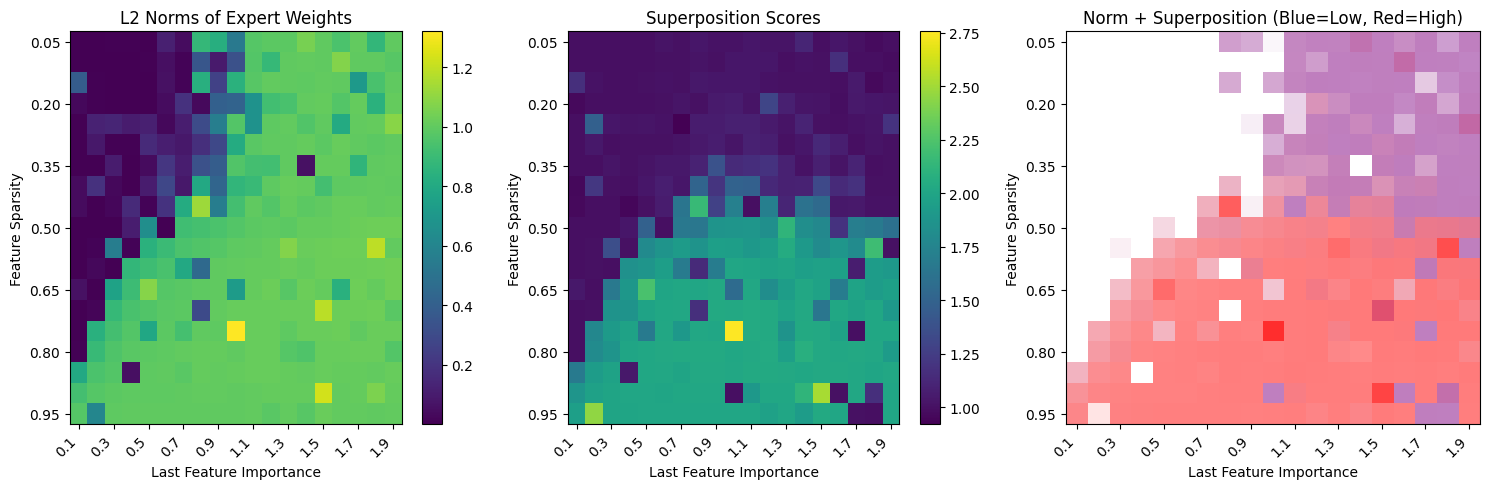


=== Summary Statistics ===
Grid size: 19 x 19 = 361 points
Mean norm: 0.737 ± 0.403
Mean superposition: 1.464 ± 0.468
Min norm: 0.000, Max norm: 1.321
Min superposition: 0.922, Max superposition: 2.756

=== Parameter Region Analysis ===
low_sparsity_low_importance:
  Mean norm: 0.162 ± 0.244
  Mean superposition: 1.060 ± 0.170
low_sparsity_high_importance:
  Mean norm: 0.939 ± 0.154
  Mean superposition: 1.086 ± 0.153
high_sparsity_low_importance:
  Mean norm: 0.745 ± 0.383
  Mean superposition: 1.730 ± 0.404
high_sparsity_high_importance:
  Mean norm: 1.015 ± 0.059
  Mean superposition: 1.893 ± 0.302


In [115]:
grid_results = analyze_grid_models(training_results)

# Create norm and superposition analysis
print("\n=== Analyzing Norm and Superposition ===")

sparsity_values = config.sparsity_values
importance_values = config.importance_values


for expert_id in range(config.n_experts):
    print(f"Analyzing expert {expert_id}")

    # Store metrics for each grid cell
    norm_grid = np.zeros((len(sparsity_values), len(importance_values)))
    superposition_grid = np.zeros((len(sparsity_values), len(importance_values)))
    color_grid = np.zeros((len(sparsity_values), len(importance_values), 3))

    # Analyze each grid cell
    for i, sparsity in enumerate(sparsity_values):
        for j, importance in enumerate(importance_values):
            result = grid_results[(sparsity, importance)]
            
            # Get expert weights (shape: [1, 2, 1] -> [2, 1])
            expert_weights = result['expert_weights']  # First (and only) expert
            
            # Get weights for this expert
            expert_weight_matrix = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
            
            expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[-1]
            # print(expert_metrics)
            # print(expert_metrics['x_coord'])
            # print(expert_metrics['y_coord'])
            # fig.add_trace(go.Scatter(
            #     x=[expert_metrics['x_coord']],
            #     y=[expert_metrics['y_coord']], 
            #     mode='markers',
            #     marker=dict(size=15, color='black', symbol='x'),
            #     name='Experts'
            # ))
            norm_grid[i, j] = expert_metrics['norm']
            superposition_grid[i, j] = expert_metrics['super_score']

    # Analyze each grid cell
    for i, sparsity in enumerate(sparsity_values):
        for j, importance in enumerate(importance_values):
            result = grid_results[(sparsity, importance)]
            expert_weights = result['expert_weights']  # First (and only) expert
            
            # Get weights for this expert
            expert_weight_matrix = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
            
            expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[-1]

            # Store RGB values for color visualization
            # Convert hex to RGB or use color_from_metrics directly
            rgb_color = color_from_metrics(
                expert_metrics['norm']-0.5, 
                expert_metrics['super_score']/2,
                max_norm=1, #np.max(norm_grid),  # You might want to compute actual max values
                max_super=1 #np.max(superposition_grid)
            )
            color_grid[i, j] = rgb_color
            

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Norms
    im1 = axes[0].imshow(norm_grid, cmap='viridis', aspect='auto')
    axes[0].set_xlabel('Last Feature Importance')
    axes[0].set_ylabel('Feature Sparsity')
    axes[0].set_title('L2 Norms of Expert Weights')
    plt.colorbar(im1, ax=axes[0])

    # Plot 2: Superposition
    im2 = axes[1].imshow(superposition_grid, cmap='viridis', aspect='auto')
    axes[1].set_xlabel('Last Feature Importance')
    axes[1].set_ylabel('Feature Sparsity')
    axes[1].set_title('Superposition Scores')
    plt.colorbar(im2, ax=axes[1])

    # Plot 3: Combined color visualization
    im3 = axes[2].imshow(color_grid, aspect='auto')
    axes[2].set_xlabel('Last Feature Importance')
    axes[2].set_ylabel('Feature Sparsity')
    axes[2].set_title('Norm + Superposition (Blue=Low, Red=High)')

    # Set tick labels
    for ax in axes:
        x_step = max(1, len(importance_values) // 8)
        y_step = max(1, len(sparsity_values) // 6)
        
        x_ticks = range(0, len(importance_values), x_step)
        y_ticks = range(0, len(sparsity_values), y_step)
        
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])

    plt.tight_layout()
    plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(grid_results)} points")
print(f"Mean norm: {np.mean(norm_grid):.3f} ± {np.std(norm_grid):.3f}")
print(f"Mean superposition: {np.mean(superposition_grid):.3f} ± {np.std(superposition_grid):.3f}")
print(f"Min norm: {np.min(norm_grid):.3f}, Max norm: {np.max(norm_grid):.3f}")
print(f"Min superposition: {np.min(superposition_grid):.3f}, Max superposition: {np.max(superposition_grid):.3f}")

# Analyze parameter regions
print("\n=== Parameter Region Analysis ===")
mid_sparsity = len(sparsity_values) // 2
mid_importance = len(importance_values) // 2

regions = {
    'low_sparsity_low_importance': (0, mid_sparsity, 0, mid_importance),
    'low_sparsity_high_importance': (0, mid_sparsity, mid_importance, len(importance_values)),
    'high_sparsity_low_importance': (mid_sparsity, len(sparsity_values), 0, mid_importance),
    'high_sparsity_high_importance': (mid_sparsity, len(sparsity_values), mid_importance, len(importance_values))
}

for region_name, (i_start, i_end, j_start, j_end) in regions.items():
    region_norms = norm_grid[i_start:i_end, j_start:j_end]
    region_super = superposition_grid[i_start:i_end, j_start:j_end]
    
    print(f"{region_name}:")
    print(f"  Mean norm: {np.mean(region_norms):.3f} ± {np.std(region_norms):.3f}")
    print(f"  Mean superposition: {np.mean(region_super):.3f} ± {np.std(region_super):.3f}")

In [116]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phase_changes.sparsity_importance_grid_experiment import *
from helpers.expert_classification import *

# Set random seed
torch.manual_seed(np.random.randint(0, 10000))

# Create configuration for n=2, m=1, k=1, e=1
config = GridExperimentConfig()
config.n_features = 3  # n=2
config.n_hidden = 1    # m=1  
config.n_experts = 1   # k=1
config.n_active_experts = 1  # e=1
config.steps = 3000     # Shorter training for faster experiments
config.n_models_per_cell = 5

# Run the experiment
print("=== Training Grid Models ===")
training_results_311_5 = train_grid_models(config)


=== Training Grid Models ===
Creating grid with 19 sparsity values and 19 importance values
Total grid points: 361
Training 5 independent runs...
Training run 1/5...
Step 0: avg_loss=0.393407, lr=0.001000
Step 750: avg_loss=0.118867, lr=0.001000
Step 1500: avg_loss=0.086037, lr=0.001000
Step 2250: avg_loss=0.078783, lr=0.001000
Step 2999: avg_loss=0.077192, lr=0.001000
Training run 2/5...
Step 0: avg_loss=0.364065, lr=0.001000
Step 2999: avg_loss=0.079146, lr=0.001000
Training run 3/5...
Step 0: avg_loss=0.367382, lr=0.001000
Step 2999: avg_loss=0.080132, lr=0.001000
Training run 4/5...
Step 0: avg_loss=0.347352, lr=0.001000
Step 2999: avg_loss=0.080416, lr=0.001000
Training run 5/5...
Step 0: avg_loss=0.368609, lr=0.001000
Step 2999: avg_loss=0.078115, lr=0.001000
Selecting best models per grid cell...
  Cell (0.05, 0.1): best loss 0.041026 (run 4)
  Cell (0.05, 0.2): best loss 0.043666 (run 2)
  Cell (0.05, 0.3): best loss 0.049299 (run 3)
  Cell (0.05, 0.4): best loss 0.054597 (run 

Analyzing expert allocations for all grid points...

=== Analyzing Norm and Superposition ===
Analyzing expert 0


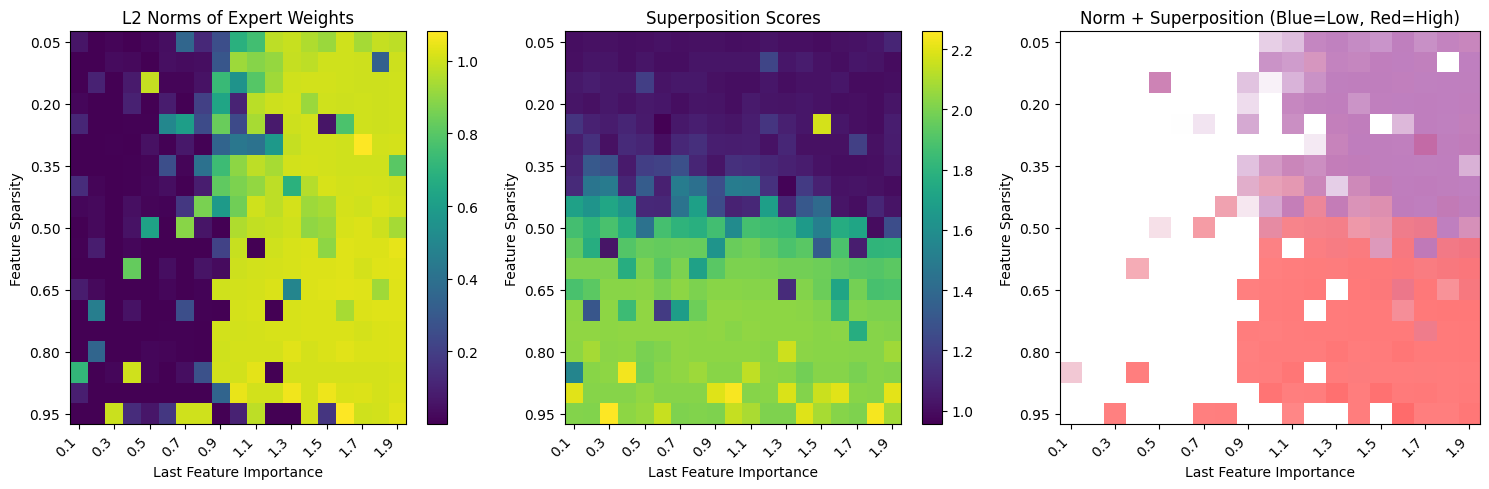


=== Summary Statistics ===
Grid size: 19 x 19 = 361 points
Mean norm: 0.555 ± 0.464
Mean superposition: 1.549 ± 0.465
Min norm: 0.000, Max norm: 1.080
Min superposition: 0.955, Max superposition: 2.259

=== Parameter Region Analysis ===
low_sparsity_low_importance:
  Mean norm: 0.142 ± 0.243
  Mean superposition: 1.133 ± 0.186
low_sparsity_high_importance:
  Mean norm: 0.899 ± 0.216
  Mean superposition: 1.077 ± 0.164
high_sparsity_low_importance:
  Mean norm: 0.158 ± 0.314
  Mean superposition: 1.950 ± 0.195
high_sparsity_high_importance:
  Mean norm: 0.937 ± 0.254
  Mean superposition: 1.948 ± 0.220


In [117]:
grid_results_211_5 = analyze_grid_models(training_results_311_5)

# Create norm and superposition analysis
print("\n=== Analyzing Norm and Superposition ===")

sparsity_values = config.sparsity_values
importance_values = config.importance_values


for expert_id in range(config.n_experts):
    print(f"Analyzing expert {expert_id}")

    # Store metrics for each grid cell
    norm_grid = np.zeros((len(sparsity_values), len(importance_values)))
    superposition_grid = np.zeros((len(sparsity_values), len(importance_values)))
    color_grid = np.zeros((len(sparsity_values), len(importance_values), 3))

    # Analyze each grid cell
    for i, sparsity in enumerate(sparsity_values):
        for j, importance in enumerate(importance_values):
            result = grid_results_211_5[(sparsity, importance)]
            
            # Get expert weights (shape: [1, 2, 1] -> [2, 1])
            expert_weights = result['expert_weights']  # First (and only) expert
            
            # Get weights for this expert
            expert_weight_matrix = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
            
            expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[-1]
            # print(expert_metrics)
            # print(expert_metrics['x_coord'])
            # print(expert_metrics['y_coord'])
            # fig.add_trace(go.Scatter(
            #     x=[expert_metrics['x_coord']],
            #     y=[expert_metrics['y_coord']], 
            #     mode='markers',
            #     marker=dict(size=15, color='black', symbol='x'),
            #     name='Experts'
            # ))
            norm_grid[i, j] = expert_metrics['norm']
            superposition_grid[i, j] = expert_metrics['super_score']

    # Analyze each grid cell
    for i, sparsity in enumerate(sparsity_values):
        for j, importance in enumerate(importance_values):
            result = grid_results_211_5[(sparsity, importance)]
            expert_weights = result['expert_weights']  # First (and only) expert
            
            # Get weights for this expert
            expert_weight_matrix = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
            
            expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[-1]

            # Store RGB values for color visualization
            # Convert hex to RGB or use color_from_metrics directly
            rgb_color = color_from_metrics(
                expert_metrics['norm']-0.5, 
                expert_metrics['super_score']/2,
                max_norm=1, #np.max(norm_grid),  # You might want to compute actual max values
                max_super=1 #np.max(superposition_grid)
            )
            color_grid[i, j] = rgb_color
            

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Norms
    im1 = axes[0].imshow(norm_grid, cmap='viridis', aspect='auto')
    axes[0].set_xlabel('Last Feature Importance')
    axes[0].set_ylabel('Feature Sparsity')
    axes[0].set_title('L2 Norms of Expert Weights')
    plt.colorbar(im1, ax=axes[0])

    # Plot 2: Superposition
    im2 = axes[1].imshow(superposition_grid, cmap='viridis', aspect='auto')
    axes[1].set_xlabel('Last Feature Importance')
    axes[1].set_ylabel('Feature Sparsity')
    axes[1].set_title('Superposition Scores')
    plt.colorbar(im2, ax=axes[1])

    # Plot 3: Combined color visualization
    im3 = axes[2].imshow(color_grid, aspect='auto')
    axes[2].set_xlabel('Last Feature Importance')
    axes[2].set_ylabel('Feature Sparsity')
    axes[2].set_title('Norm + Superposition (Blue=Low, Red=High)')

    # Set tick labels
    for ax in axes:
        x_step = max(1, len(importance_values) // 8)
        y_step = max(1, len(sparsity_values) // 6)
        
        x_ticks = range(0, len(importance_values), x_step)
        y_ticks = range(0, len(sparsity_values), y_step)
        
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])

    plt.tight_layout()
    plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(grid_results_211_5)} points")
print(f"Mean norm: {np.mean(norm_grid):.3f} ± {np.std(norm_grid):.3f}")
print(f"Mean superposition: {np.mean(superposition_grid):.3f} ± {np.std(superposition_grid):.3f}")
print(f"Min norm: {np.min(norm_grid):.3f}, Max norm: {np.max(norm_grid):.3f}")
print(f"Min superposition: {np.min(superposition_grid):.3f}, Max superposition: {np.max(superposition_grid):.3f}")

# Analyze parameter regions
print("\n=== Parameter Region Analysis ===")
mid_sparsity = len(sparsity_values) // 2
mid_importance = len(importance_values) // 2

regions = {
    'low_sparsity_low_importance': (0, mid_sparsity, 0, mid_importance),
    'low_sparsity_high_importance': (0, mid_sparsity, mid_importance, len(importance_values)),
    'high_sparsity_low_importance': (mid_sparsity, len(sparsity_values), 0, mid_importance),
    'high_sparsity_high_importance': (mid_sparsity, len(sparsity_values), mid_importance, len(importance_values))
}

for region_name, (i_start, i_end, j_start, j_end) in regions.items():
    region_norms = norm_grid[i_start:i_end, j_start:j_end]
    region_super = superposition_grid[i_start:i_end, j_start:j_end]
    
    print(f"{region_name}:")
    print(f"  Mean norm: {np.mean(region_norms):.3f} ± {np.std(region_norms):.3f}")
    print(f"  Mean superposition: {np.mean(region_super):.3f} ± {np.std(region_super):.3f}")

In [121]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phase_changes.sparsity_importance_grid_experiment import *
from helpers.expert_classification import *

# Set random seed
torch.manual_seed(np.random.randint(0, 10000))

# Create configuration for n=2, m=1, k=1, e=1
config = GridExperimentConfig()
config.n_features = 3  # n=2
config.n_hidden = 1    # m=1  
config.n_experts = 2   # k=1
config.n_active_experts = 1  # e=1
config.steps = 3000     # Shorter training for faster experiments
config.n_models_per_cell = 5

# Run the experiment
print("=== Training Grid Models ===")
training_results_312_5 = train_grid_models(config)


=== Training Grid Models ===
Creating grid with 19 sparsity values and 19 importance values
Total grid points: 361
Training 5 independent runs...
Training run 1/5...
Step 0: avg_loss=0.306900, lr=0.001000
Step 750: avg_loss=0.096284, lr=0.001000
Step 1500: avg_loss=0.076858, lr=0.001000
Step 2250: avg_loss=0.072463, lr=0.001000
Step 2999: avg_loss=0.071411, lr=0.001000
Training run 2/5...
Step 0: avg_loss=0.268305, lr=0.001000
Step 2999: avg_loss=0.067463, lr=0.001000
Training run 3/5...
Step 0: avg_loss=0.325103, lr=0.001000
Step 2999: avg_loss=0.067575, lr=0.001000
Training run 4/5...
Step 0: avg_loss=0.279279, lr=0.001000
Step 2999: avg_loss=0.070176, lr=0.001000
Training run 5/5...
Step 0: avg_loss=0.279462, lr=0.001000
Step 2999: avg_loss=0.069102, lr=0.001000
Selecting best models per grid cell...
  Cell (0.05, 0.1): best loss 0.045531 (run 2)
  Cell (0.05, 0.2): best loss 0.026021 (run 1)
  Cell (0.05, 0.3): best loss 0.029747 (run 1)
  Cell (0.05, 0.4): best loss 0.031251 (run 

Analyzing expert allocations for all grid points...

=== Analyzing Norm and Superposition ===
Analyzing expert 0


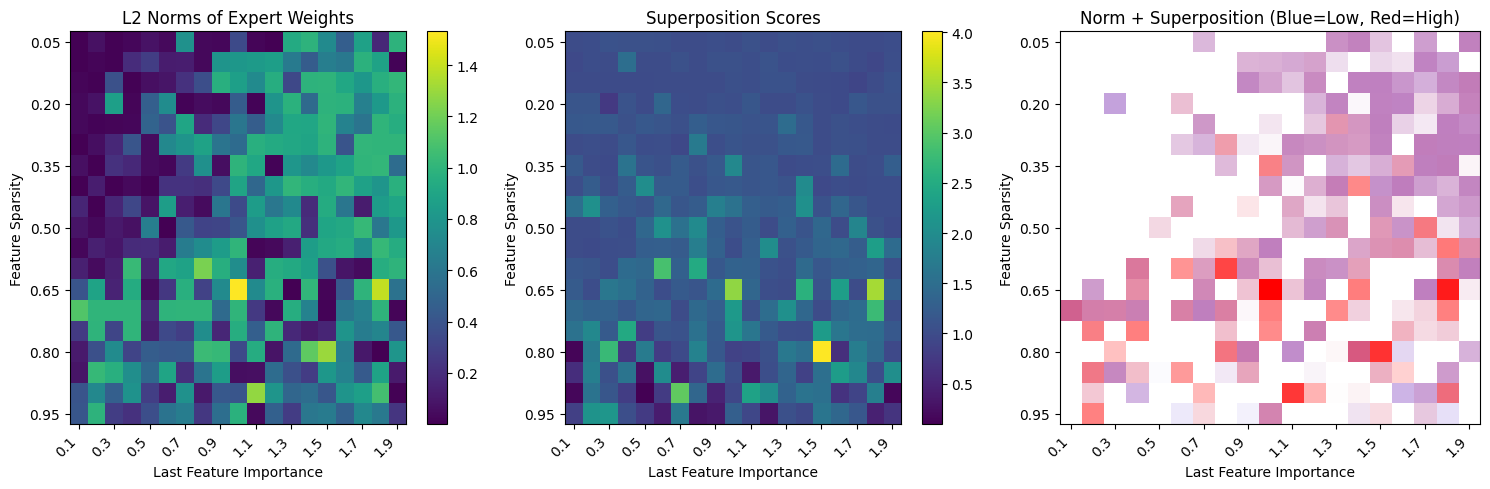

Analyzing expert 1


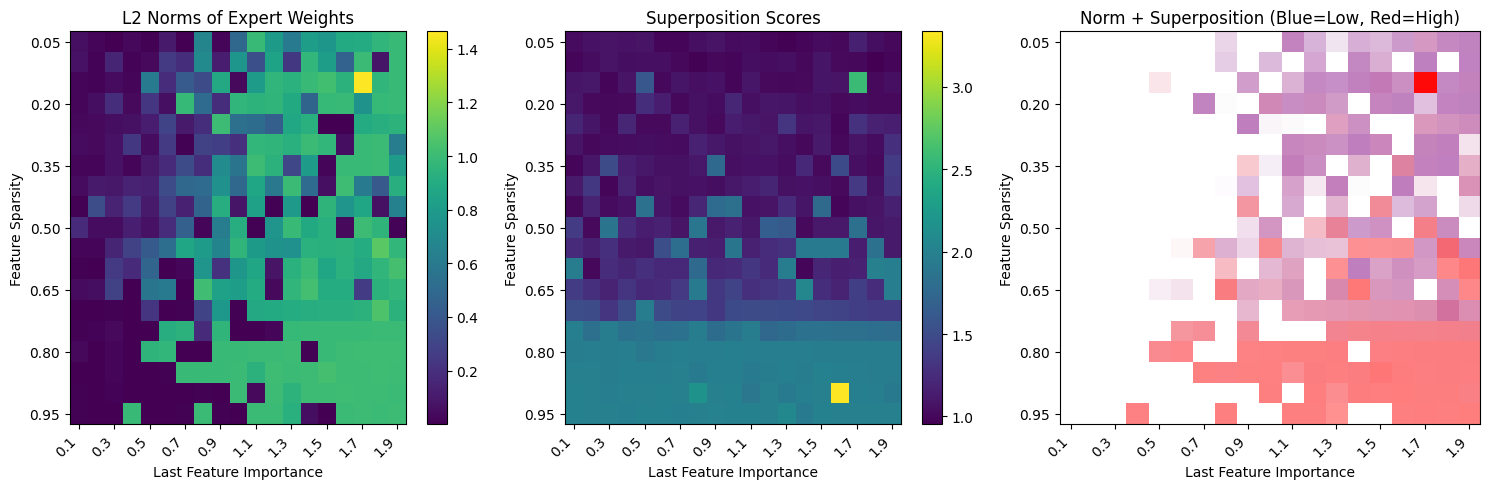


=== Summary Statistics ===
Grid size: 19 x 19 = 361 points
Mean norm: 0.521 ± 0.422
Mean superposition: 1.413 ± 0.412
Min norm: 0.000, Max norm: 1.465
Min superposition: 0.953, Max superposition: 3.336

=== Parameter Region Analysis ===
low_sparsity_low_importance:
  Mean norm: 0.214 ± 0.247
  Mean superposition: 1.107 ± 0.169
low_sparsity_high_importance:
  Mean norm: 0.727 ± 0.331
  Mean superposition: 1.115 ± 0.211
high_sparsity_low_importance:
  Mean norm: 0.259 ± 0.361
  Mean superposition: 1.664 ± 0.354
high_sparsity_high_importance:
  Mean norm: 0.819 ± 0.335
  Mean superposition: 1.703 ± 0.375


In [ ]:
grid_results_312_5 = analyze_grid_models(training_results_312_5)

# Create norm and superposition analysis
print("\n=== Analyzing Norm and Superposition ===")

sparsity_values = config.sparsity_values
importance_values = config.importance_values


for expert_id in range(config.n_experts):
    print(f"Analyzing expert {expert_id}")

    # Store metrics for each grid cell
    norm_grid = np.zeros((len(sparsity_values), len(importance_values)))
    superposition_grid = np.zeros((len(sparsity_values), len(importance_values)))
    color_grid = np.zeros((len(sparsity_values), len(importance_values), 3))

    # Analyze each grid cell
    for i, sparsity in enumerate(sparsity_values):
        for j, importance in enumerate(importance_values):
            result = grid_results_312_5[(sparsity, importance)]
            
            # Get expert weights (shape: [1, 2, 1] -> [2, 1])
            expert_weights = result['expert_weights']  # First (and only) expert
            
            # Get weights for this expert
            expert_weight_matrix = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
            
            expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[-1]
            # print(expert_metrics)
            # print(expert_metrics['x_coord'])
            # print(expert_metrics['y_coord'])
            # fig.add_trace(go.Scatter(
            #     x=[expert_metrics['x_coord']],
            #     y=[expert_metrics['y_coord']], 
            #     mode='markers',
            #     marker=dict(size=15, color='black', symbol='x'),
            #     name='Experts'
            # ))
            norm_grid[i, j] = expert_metrics['norm']
            superposition_grid[i, j] = expert_metrics['super_score']

    # Analyze each grid cell
    for i, sparsity in enumerate(sparsity_values):
        for j, importance in enumerate(importance_values):
            result = grid_results_312_5[(sparsity, importance)]
            expert_weights = result['expert_weights']  # First (and only) expert
            
            # Get weights for this expert
            expert_weight_matrix = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
            
            expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[-1]

            # Store RGB values for color visualization
            # Convert hex to RGB or use color_from_metrics directly
            rgb_color = color_from_metrics(
                expert_metrics['norm']-0.5, 
                expert_metrics['super_score']/2,
                max_norm=1, #np.max(norm_grid),  # You might want to compute actual max values
                max_super=1 #np.max(superposition_grid)
            )
            color_grid[i, j] = rgb_color
            

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Norms
    im1 = axes[0].imshow(norm_grid, cmap='viridis', aspect='auto')
    axes[0].set_xlabel('Last Feature Importance')
    axes[0].set_ylabel('Feature Sparsity')
    axes[0].set_title('L2 Norms of Expert Weights')
    plt.colorbar(im1, ax=axes[0])

    # Plot 2: Superposition
    im2 = axes[1].imshow(superposition_grid, cmap='viridis', aspect='auto')
    axes[1].set_xlabel('Last Feature Importance')
    axes[1].set_ylabel('Feature Sparsity')
    axes[1].set_title('Superposition Scores')
    plt.colorbar(im2, ax=axes[1])

    # Plot 3: Combined color visualization
    im3 = axes[2].imshow(color_grid, aspect='auto')
    axes[2].set_xlabel('Last Feature Importance')
    axes[2].set_ylabel('Feature Sparsity')
    axes[2].set_title('Norm + Superposition (Blue=Low, Red=High)')

    # Set tick labels
    for ax in axes:
        x_step = max(1, len(importance_values) // 8)
        y_step = max(1, len(sparsity_values) // 6)
        
        x_ticks = range(0, len(importance_values), x_step)
        y_ticks = range(0, len(sparsity_values), y_step)
        
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])

    plt.tight_layout()
    plt.show()

    # Create subplots
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=('L2 Norms of Expert Weights', 'Superposition Scores', 'Norm + Superposition (Blue=Low, Red=High)'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]]
    )

    # Plot 1: Norms
    fig.add_trace(
        go.Heatmap(
            z=norm_grid,
            x=importance_values,
            y=sparsity_values,
            colorscale='viridis',
            colorbar=dict(title='L2 Norm', x=0.3),
            name='Norms'
        ),
        row=1, col=1
    )

    # Plot 2: Superposition
    fig.add_trace(
        go.Heatmap(
            z=superposition_grid,
            x=importance_values,
            y=sparsity_values,
            colorscale='viridis',
            colorbar=dict(title='Superposition Score', x=0.65),
            name='Superposition'
        ),
        row=1, col=2
    )

    # Plot 3: Combined color visualization - Use go.Image for custom RGB colors
    fig.add_trace(
        go.Image(
            z=color_grid*255,
            x0=importance_values[0],
            dx=importance_values[1] - importance_values[0] if len(importance_values) > 1 else 1,
            y0=sparsity_values[0],
            dy=sparsity_values[1] - sparsity_values[0] if len(sparsity_values) > 1 else 1,
            name='Combined Colors'
        ),
        row=1, col=3
    )

    # Update layout
    fig.update_layout(
        width=1500,
        height=500,
        title_text="Expert Analysis Grid",
        showlegend=False
    )

    # Update axes labels
    fig.update_xaxes(title_text="Last Feature Importance", row=1, col=1)
    fig.update_yaxes(title_text="Feature Sparsity", row=1, col=1)
    fig.update_xaxes(title_text="Last Feature Importance", row=1, col=2)
    fig.update_yaxes(title_text="Feature Sparsity", row=1, col=2)
    fig.update_xaxes(title_text="Last Feature Importance", row=1, col=3)
    fig.update_yaxes(title_text="Feature Sparsity", row=1, col=3)

    # Set tick labels with fewer ticks for readability
    for col in [1, 2, 3]:
        x_step = max(1, len(importance_values) // 8)
        y_step = max(1, len(sparsity_values) // 6)
        
        x_ticks = np.arange(0, len(importance_values), x_step)
        y_ticks = np.arange(0, len(sparsity_values), y_step)
        
        fig.update_xaxes(
            tickmode='array',
            tickvals=x_ticks,
            ticktext=[f'{importance_values[i]:.1f}' for i in x_ticks],
            tickangle=-45,
            row=1, col=col
        )
        
        fig.update_yaxes(
            tickmode='array',
            tickvals=y_ticks,
            ticktext=[f'{sparsity_values[i]:.2f}' for i in y_ticks],
            row=1, col=col
        )

    fig.show()

            # Create visualization
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Create subplots
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=('L2 Norms of Expert Weights', 'Superposition Scores', 'Norm + Superposition (Blue=Low, Red=High)'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]]
    )

    # Plot 1: Norms
    fig.add_trace(
        go.Heatmap(
            z=norm_grid,
            x=importance_values,
            y=sparsity_values,
            colorscale='viridis',
            colorbar=dict(title='L2 Norm', x=0.3),
            name='Norms'
        ),
        row=1, col=1
    )

    # Plot 2: Superposition
    fig.add_trace(
        go.Heatmap(
            z=superposition_grid,
            x=importance_values,
            y=sparsity_values,
            colorscale='viridis',
            colorbar=dict(title='Superposition Score', x=0.65),
            name='Superposition'
        ),
        row=1, col=2
    )

    # Plot 3: Combined color visualization - Convert RGB to single value for better plotting
    # Convert your RGB color_grid to hex colors that Plotly can display
    hex_colors = np.zeros_like(color_grid[:, :, 0], dtype=object)
    for i in range(color_grid.shape[0]):
        for j in range(color_grid.shape[1]):
            r, g, b = color_grid[i, j]
            # Convert RGB (0-1) to hex - no need to multiply by 255
            hex_colors[i, j] = f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}'

    # Create a custom colormap from your colors
    unique_colors = np.unique(hex_colors)
    color_scale = []
    for i, color in enumerate(unique_colors):
        color_scale.append([i / (len(unique_colors) - 1), color])

    # Map your hex colors to indices for the colormap
    color_indices = np.zeros_like(color_grid[:, :, 0], dtype=float)
    for i, color in enumerate(unique_colors):
        color_indices[hex_colors == color] = i

    fig.add_trace(
        go.Heatmap(
            z=color_indices,
            x=importance_values,
            y=sparsity_values,
            colorscale=color_scale,
            colorbar=dict(title='Custom Colors', x=1.0),
            name='Combined Colors'
        ),
        row=1, col=3
    )

    # Update layout
    fig.update_layout(
        width=1500,
        height=500,
        title_text="Expert Analysis Grid",
        showlegend=False
    )

    # Update axes labels
    fig.update_xaxes(title_text="Last Feature Importance", row=1, col=1)
    fig.update_yaxes(title_text="Feature Sparsity", row=1, col=1)
    fig.update_xaxes(title_text="Last Feature Importance", row=1, col=2)
    fig.update_yaxes(title_text="Feature Sparsity", row=1, col=2)
    fig.update_xaxes(title_text="Last Feature Importance", row=1, col=3)
    fig.update_yaxes(title_text="Feature Sparsity", row=1, col=3)

    # Set tick labels with fewer ticks for readability
    for col in [1, 2, 3]:
        x_step = max(1, len(importance_values) // 8)
        y_step = max(1, len(sparsity_values) // 6)
        
        x_ticks = np.arange(0, len(importance_values), x_step)
        y_ticks = np.arange(0, len(sparsity_values), y_step)
        
        fig.update_xaxes(
            tickmode='array',
            tickvals=x_ticks,
            ticktext=[f'{importance_values[i]:.1f}' for i in x_ticks],
            tickangle=-45,
            row=1, col=col
        )
        
        fig.update_yaxes(
            tickmode='array',
            tickvals=y_ticks,
            ticktext=[f'{sparsity_values[i]:.2f}' for i in y_ticks],
            row=1, col=col
        )

    fig.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(grid_results_312_5)} points")
print(f"Mean norm: {np.mean(norm_grid):.3f} ± {np.std(norm_grid):.3f}")
print(f"Mean superposition: {np.mean(superposition_grid):.3f} ± {np.std(superposition_grid):.3f}")
print(f"Min norm: {np.min(norm_grid):.3f}, Max norm: {np.max(norm_grid):.3f}")
print(f"Min superposition: {np.min(superposition_grid):.3f}, Max superposition: {np.max(superposition_grid):.3f}")

# Analyze parameter regions
print("\n=== Parameter Region Analysis ===")
mid_sparsity = len(sparsity_values) // 2
mid_importance = len(importance_values) // 2

regions = {
    'low_sparsity_low_importance': (0, mid_sparsity, 0, mid_importance),
    'low_sparsity_high_importance': (0, mid_sparsity, mid_importance, len(importance_values)),
    'high_sparsity_low_importance': (mid_sparsity, len(sparsity_values), 0, mid_importance),
    'high_sparsity_high_importance': (mid_sparsity, len(sparsity_values), mid_importance, len(importance_values))
}

for region_name, (i_start, i_end, j_start, j_end) in regions.items():
    region_norms = norm_grid[i_start:i_end, j_start:j_end]
    region_super = superposition_grid[i_start:i_end, j_start:j_end]
    
    print(f"{region_name}:")
    print(f"  Mean norm: {np.mean(region_norms):.3f} ± {np.std(region_norms):.3f}")
    print(f"  Mean superposition: {np.mean(region_super):.3f} ± {np.std(region_super):.3f}")

# Simplest Model